Using device: cpu

Training Model | KL-Divergence: OFF
Epoch [1/10] | Reconstruction Loss: 271.42
Epoch [2/10] | Reconstruction Loss: 256.88
Epoch [3/10] | Reconstruction Loss: 254.08
Epoch [4/10] | Reconstruction Loss: 252.41
Epoch [5/10] | Reconstruction Loss: 251.21
Epoch [6/10] | Reconstruction Loss: 250.58
Epoch [7/10] | Reconstruction Loss: 249.70
Epoch [8/10] | Reconstruction Loss: 249.51
Epoch [9/10] | Reconstruction Loss: 249.26
Epoch [10/10] | Reconstruction Loss: 248.60

Training Model | KL-Divergence: ON
Epoch [1/10] | Reconstruction Loss: 274.01
Epoch [2/10] | Reconstruction Loss: 258.61
Epoch [3/10] | Reconstruction Loss: 255.93
Epoch [4/10] | Reconstruction Loss: 254.31
Epoch [5/10] | Reconstruction Loss: 253.05
Epoch [6/10] | Reconstruction Loss: 252.01
Epoch [7/10] | Reconstruction Loss: 251.44
Epoch [8/10] | Reconstruction Loss: 250.86
Epoch [9/10] | Reconstruction Loss: 250.17
Epoch [10/10] | Reconstruction Loss: 250.52


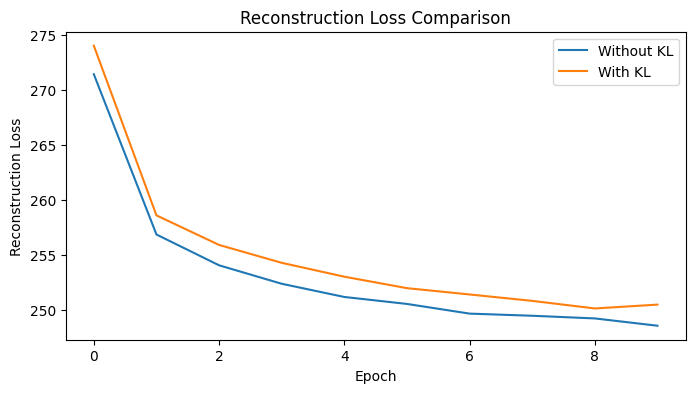

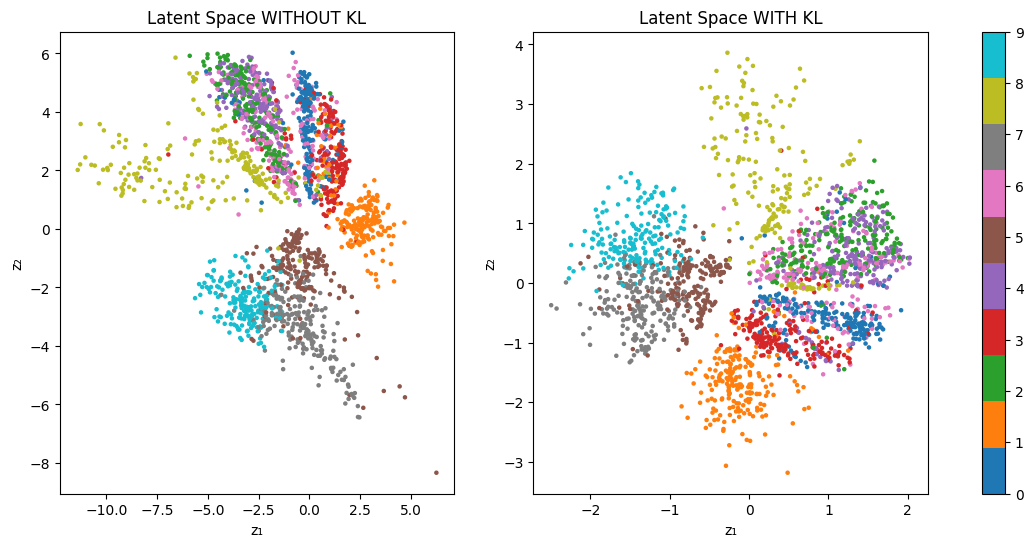

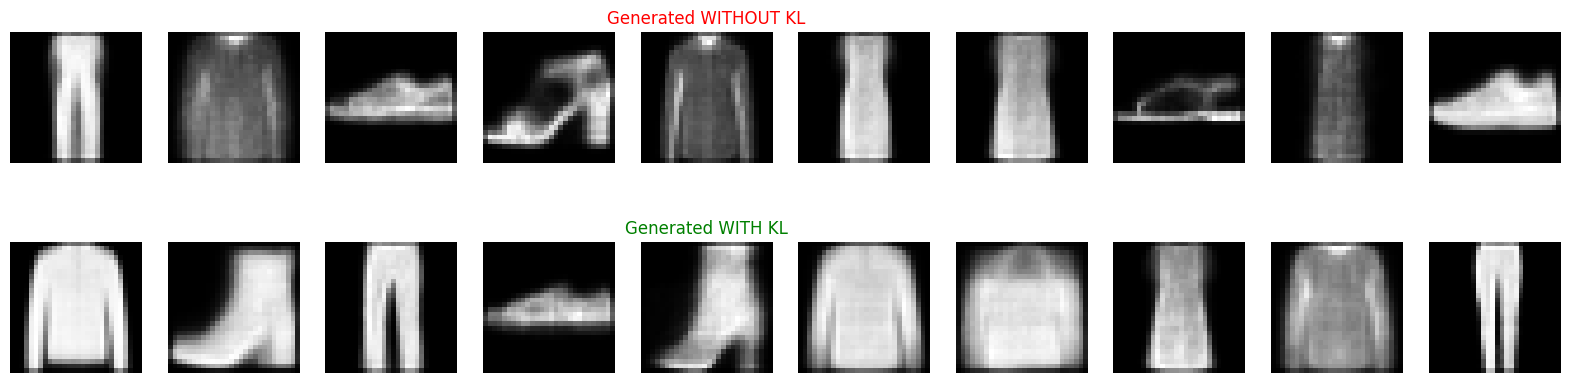

Final Reconstruction Loss WITHOUT KL: 248.60
Final Reconstruction Loss WITH KL:    250.52


In [ ]:

"""
Experiment 2:
Understanding the Role of KL-Divergence in Variational Autoencoders
Dataset: Fashion-MNIST
"""

# Imports

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters

BATCH_SIZE = 64
LATENT_DIM = 2
EPOCHS = 10
LEARNING_RATE = 1e-3


# Task 1: Dataset Preparation

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = datasets.FashionMNIST(
    root="./data", train=False, transform=transform, download=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# Task 2: VAE Architecture

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


# Task 3 & 4: Training Function

def train_model(use_kld=True):
    model = VAE(LATENT_DIM).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    recon_loss_history = []

    print(f"\nTraining Model | KL-Divergence: {'ON' if use_kld else 'OFF'}")

    for epoch in range(EPOCHS):
        model.train()
        total_recon_loss = 0

        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()

            recon, mu, logvar = model(x)

            # Reconstruction Loss
            recon_loss = nn.functional.binary_cross_entropy(
                recon, x.view(-1, 784), reduction="sum"
            )

            # KL Divergence Loss
            if use_kld:
                kld_loss = -0.5 * torch.sum(
                    1 + logvar - mu.pow(2) - logvar.exp()
                )
            else:
                kld_loss = torch.tensor(0.0).to(device)

            loss = recon_loss + kld_loss
            loss.backward()
            optimizer.step()

            total_recon_loss += recon_loss.item()

        avg_loss = total_recon_loss / len(train_loader.dataset)
        recon_loss_history.append(avg_loss)

        print(f"Epoch [{epoch+1}/{EPOCHS}] | Reconstruction Loss: {avg_loss:.2f}")

    return model, recon_loss_history


# Run Experiment

model_no_kl, loss_no_kl = train_model(use_kld=False)
model_with_kl, loss_with_kl = train_model(use_kld=True)


# Task 6: Latent Space Visualization

def plot_latent_spaces(model_no_kl, model_with_kl):
    model_no_kl.eval()
    model_with_kl.eval()

    z_no, z_yes, labels_all = [], [], []

    with torch.no_grad():
        for x, labels in test_loader:
            x = x.to(device)

            mu_no, _ = model_no_kl.encode(x.view(-1, 784))
            mu_yes, _ = model_with_kl.encode(x.view(-1, 784))

            z_no.append(mu_no.cpu())
            z_yes.append(mu_yes.cpu())
            labels_all.append(labels)

            if len(z_no) * BATCH_SIZE > 2000:
                break

    z_no = torch.cat(z_no).numpy()
    z_yes = torch.cat(z_yes).numpy()
    labels = torch.cat(labels_all).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    scatter1 = axes[0].scatter(
        z_no[:, 0], z_no[:, 1], c=labels, cmap="tab10", s=5
    )
    axes[0].set_title("Latent Space WITHOUT KL")
    axes[0].set_xlabel("z₁")
    axes[0].set_ylabel("z₂")

    scatter2 = axes[1].scatter(
        z_yes[:, 0], z_yes[:, 1], c=labels, cmap="tab10", s=5
    )
    axes[1].set_title("Latent Space WITH KL")
    axes[1].set_xlabel("z₁")
    axes[1].set_ylabel("z₂")

    plt.colorbar(scatter2, ax=axes.ravel().tolist())
    plt.show()

# Task 5: Sample Generation

def generate_samples(model_no_kl, model_with_kl):
    z = torch.randn(10, LATENT_DIM).to(device)

    with torch.no_grad():
        gen_no = model_no_kl.decode(z).view(10, 28, 28).cpu()
        gen_yes = model_with_kl.decode(z).view(10, 28, 28).cpu()

    fig, axes = plt.subplots(2, 10, figsize=(20, 5))

    for i in range(10):
        axes[0, i].imshow(gen_no[i], cmap="gray")
        axes[0, i].axis("off")

        axes[1, i].imshow(gen_yes[i], cmap="gray")
        axes[1, i].axis("off")

    axes[0, 4].set_title("Generated WITHOUT KL", color="red")
    axes[1, 4].set_title("Generated WITH KL", color="green")

    plt.show()


# Loss Curve Comparison

plt.figure(figsize=(8, 4))
plt.plot(loss_no_kl, label="Without KL")
plt.plot(loss_with_kl, label="With KL")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.title("Reconstruction Loss Comparison")
plt.legend()
plt.show()


# Run Visualizations

plot_latent_spaces(model_no_kl, model_with_kl)
generate_samples(model_no_kl, model_with_kl)


# Final Observation

print(f"Final Reconstruction Loss WITHOUT KL: {loss_no_kl[-1]:.2f}")
print(f"Final Reconstruction Loss WITH KL:    {loss_with_kl[-1]:.2f}")
